In [1]:
from google.colab import files 
import numpy as np 

from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Input 
from tensorflow.keras.optimizers import RMSprop, Adadelta 
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras import utils 
from tensorflow.keras.utils import plot_model 

import yaml 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Открываем файл с диалогами

corpus = open('/content/drive/My Drive/datasets/texts/Диалоги(рассказы).yml', 'r') # открываем файл с диалогами в режиме чтения
document = yaml.safe_load(corpus) # загружаем файл *глоссарий
conversations = document['разговоры'] # загружаем диалоги из файла и заносим в conversations 
print('Количество пар вопрос-ответ : {}'.format(len(conversations)))
print('Пример диалога : {}'.format(conversations[125]))

Количество пар вопрос-ответ : 11905
Пример диалога : ['Кто будете?', 'Колхозник.']


In [4]:
# Разбираем вопросы-ответы с проставлением тегов ответам

# Собираем вопросы и ответы в списки
# здесь будет список вопросов
questions = list() 
# здесь будет список ответов
answers = list() 


for con in conversations:
  if len(con) > 2 : 
    questions.append(con[0]) 
    replies = con[1:] 
    ans = '' 
    for rep in replies: 
      ans += ' ' + rep 
    answers.append(ans) 
  elif len(con)> 1: 
    questions.append(con[0]) 
    answers.append(con[1])

# Очищаем строки с неопределенным типов ответов
answersCleaned = list()
for i in range(len(answers)):
  if type(answers[i]) == str:
    answersCleaned.append(answers[i])
  else:
    questions.pop(i) 

# Сделаем теги-метки для начала и конца ответов
answers = list()
for i in range(len(answersCleaned)):
  answers.append( '<START> ' + answersCleaned[i] + ' <END>' )

# Выведем обновленные данные на экран
print('Вопрос : {}'.format(questions[200]))
print('Ответ : {}'.format(answers[200]))

Вопрос : Около сотни...
Ответ : <START> Точнее! <END>


In [5]:
# Подключаем керасовский токенизатор и собираем словарь индексов

tokenizer = Tokenizer()
tokenizer.fit_on_texts(questions + answers)
vocabularyItems = list(tokenizer.word_index.items())
vocabularySize = len(vocabularyItems)+1
print( 'Фрагмент словаря : {}'.format(vocabularyItems[:50]))
print( 'Размер словаря : {}'.format(vocabularySize))

Фрагмент словаря : [('start', 1), ('end', 2), ('что', 3), ('не', 4), ('я', 5), ('а', 6), ('ты', 7), ('это', 8), ('да', 9), ('в', 10), ('нет', 11), ('как', 12), ('и', 13), ('вы', 14), ('ну', 15), ('с', 16), ('на', 17), ('же', 18), ('так', 19), ('он', 20), ('у', 21), ('кто', 22), ('где', 23), ('все', 24), ('мы', 25), ('то', 26), ('мне', 27), ('тебя', 28), ('меня', 29), ('здесь', 30), ('еще', 31), ('почему', 32), ('о', 33), ('там', 34), ('тебе', 35), ('есть', 36), ('его', 37), ('за', 38), ('куда', 39), ('вот', 40), ('ничего', 41), ('вас', 42), ('знаю', 43), ('чем', 44), ('но', 45), ('она', 46), ('они', 47), ('ли', 48), ('чего', 49), ('вам', 50)]
Размер словаря : 15104


In [6]:
# Устанавливаем закодированные входные данные(вопросы)

tokenizedQuestions = tokenizer.texts_to_sequences(questions) 
maxLenQuestions = max([ len(x) for x in tokenizedQuestions]) 
# Делаем последовательности одной длины, заполняя нулями более короткие вопросы
paddedQuestions = pad_sequences(tokenizedQuestions, maxlen=maxLenQuestions, padding='post')

encoderForInput = np.array(paddedQuestions)
print('Пример оригинального вопроса на вход : {}'.format(questions[100])) 
print('Пример кодированного вопроса на вход : {}'.format(encoderForInput[100])) 
print('Размеры закодированного массива вопросов на вход : {}'.format(encoderForInput.shape)) 
print('Установленная длина вопросов на вход : {}'.format(maxLenQuestions)) 

Пример оригинального вопроса на вход : Какая же мораль?
Пример кодированного вопроса на вход : [ 170   18 5709    0    0    0    0    0    0    0    0]
Размеры закодированного массива вопросов на вход : (11900, 11)
Установленная длина вопросов на вход : 11


In [7]:
# Устанавливаем раскодированные входные данные(ответы)

tokenizedAnswers = tokenizer.texts_to_sequences(answers)
maxLenAnswers = max([len(x) for x in tokenizedAnswers])
paddedAnswers = pad_sequences(tokenizedAnswers, maxlen=maxLenAnswers, padding='post')

decoderForInput = np.array(paddedAnswers)
print('Пример оригинального ответа на вход: {}'.format(answers[100])) 
print('Пример раскодированного ответа на вход : {}'.format(decoderForInput[100][:30])) 
print('Размеры раскодированного массива ответов на вход : {}'.format(decoderForInput.shape)) 
print('Установленная длина ответов на вход : {}'.format(maxLenAnswers))

Пример оригинального ответа на вход: <START> Никакой. Так просто вспомнилось. <END>
Пример раскодированного ответа на вход : [    1   673    19    93 10558     2     0     0     0     0     0     0
     0]
Размеры раскодированного массива ответов на вход : (11900, 13)
Установленная длина ответов на вход : 13


In [8]:
# Раскодированные выходные данные(ответы)

tokenizedAnswers = tokenizer.texts_to_sequences(answers)
for i in range(len(tokenizedAnswers)) : 
  tokenizedAnswers[i] = tokenizedAnswers[i][1:]
paddedAnswers = pad_sequences(tokenizedAnswers, maxlen=maxLenAnswers , padding='post')

oneHotAnswers = utils.to_categorical(paddedAnswers, vocabularySize)
decoderForOutput = np.array(oneHotAnswers)
print('Пример раскодированного ответа на вход : {}'.format(decoderForInput[100][:21]))  
print('Пример раскодированного ответа на выход : {}'.format(decoderForOutput[100][4][:21])) 
print('Размеры раскодированного массива ответов на выход : {}'.format(decoderForOutput.shape))
print('Установленная длина вопросов на выход : {}'.format(maxLenAnswers)) 

Пример раскодированного ответа на вход : [    1   673    19    93 10558     2     0     0     0     0     0     0
     0]
Пример раскодированного ответа на выход : [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Размеры раскодированного массива ответов на выход : (11900, 13, 15104)
Установленная длина вопросов на выход : 13


In [9]:
# Первый входной слой, кодер, выходной слой
encoderInputs = Input(shape=(11, ))
encoderEmbedding = Embedding(vocabularySize, 200,  mask_zero=True) (encoderInputs)
encoderOutputs, state_h , state_c = LSTM(200, return_state=True)(encoderEmbedding)
encoderStates = [state_h, state_c]

In [10]:
# Второй входной слой, декодер, выходной слой
decoderInputs = Input(shape=(13, ))
decoderEmbedding = Embedding(vocabularySize, 200, mask_zero=True) (decoderInputs) 
decoderLSTM = LSTM(200, return_state=True, return_sequences=True)
decoderOutputs , _ , _ = decoderLSTM (decoderEmbedding, initial_state=encoderStates)
decoderDense = Dense(vocabularySize, activation='softmax') 
output = decoderDense (decoderOutputs)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 11)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 13)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 11, 200)      3020800     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 13, 200)      3020800     input_2[0][0]                    
_______________________________________________________________________________________

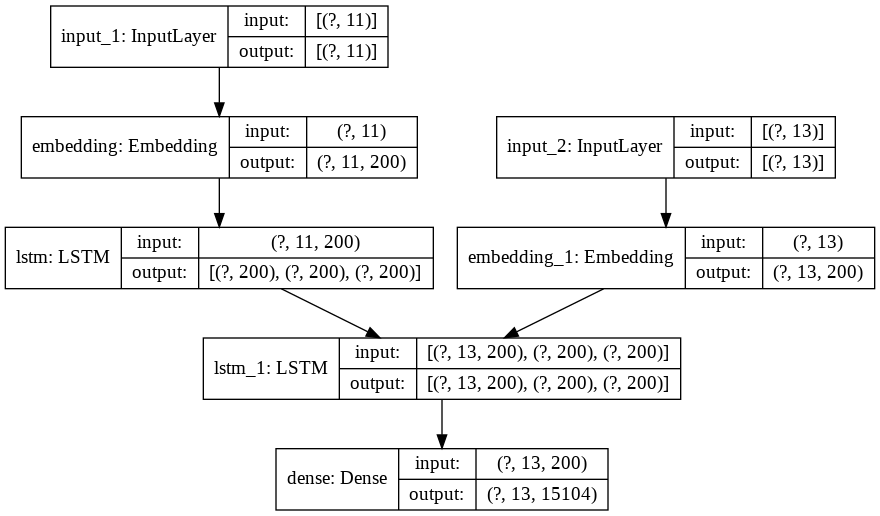

In [11]:
# Собираем тренировочную модель нейросети
model = Model([encoderInputs, decoderInputs], output)
model.compile(optimizer=RMSprop(), loss='categorical_crossentropy')
print(model.summary()) 
plot_model(model, to_file='model.png', show_shapes=True)

20 Epochs

In [12]:
# Запустим обучение и сохраним модель
model.fit([encoderForInput , decoderForInput], decoderForOutput, batch_size=50, epochs=20) 
# model.save( '/content/drive/My Drive/Models/model_20epochs(rms).h5' )

Epoch 1/20
238/238 [==============================] - 10s 41ms/step - loss: 2.2171
Epoch 2/20
238/238 [==============================] - 10s 41ms/step - loss: 1.9766
Epoch 3/20
238/238 [==============================] - 10s 41ms/step - loss: 1.9268
Epoch 4/20
238/238 [==============================] - 10s 41ms/step - loss: 1.8886
Epoch 5/20
238/238 [==============================] - 10s 41ms/step - loss: 1.8540
Epoch 6/20
238/238 [==============================] - 10s 41ms/step - loss: 1.8213
Epoch 7/20
238/238 [==============================] - 10s 42ms/step - loss: 1.7906
Epoch 8/20
238/238 [==============================] - 10s 41ms/step - loss: 1.7602
Epoch 9/20
238/238 [==============================] - 10s 41ms/step - loss: 1.7295
Epoch 10/20
238/238 [==============================] - 10s 41ms/step - loss: 1.6963
Epoch 11/20
238/238 [==============================] - 10s 41ms/step - loss: 1.6628
Epoch 12/20
238/238 [==============================] - 10s 41ms/step - loss: 1.6274
E

In [14]:
# Создаем рабочую модель для вывода ответов на запросы пользователя

def makeInferenceModels():
  encoderModel = Model(encoderInputs, encoderStates) 
  decoderStateInput_h = Input(shape=(200 ,)) 
  decoderStateInput_c = Input(shape=(200 ,)) 
  decoderStatesInputs = [decoderStateInput_h, decoderStateInput_c]
  decoderOutputs, state_h, state_c = decoderLSTM(decoderEmbedding, initial_state=decoderStatesInputs)
  decoderStates = [state_h, state_c] 
  decoderOutputs = decoderDense(decoderOutputs)
  decoderModel = Model([decoderInputs] + decoderStatesInputs, [decoderOutputs] + decoderStates)
  return encoderModel , decoderModel


# Создадим функцию, которая преобразует вопрос пользователя в последовательность индексов
def strToTokens(sentence: str): 
  words = sentence.lower().split()
  tokensList = list()
  for word in words:
    tokensList.append(tokenizer.word_index[word])
  return pad_sequences([tokensList], maxlen=maxLenQuestions , padding='post')

# Устанавливаем окончательные настройки и запускаем модель
encModel, decModel = makeInferenceModels()
for _ in range(6):
  statesValues = encModel.predict(strToTokens(input( 'Задайте вопрос : ' )))
  emptyTargetSeq = np.zeros((1, 1))    
  emptyTargetSeq[0, 0] = tokenizer.word_index['start']
  stopCondition = False 
  decodedTranslation = ''
  while not stopCondition :
    decOutputs , h , c = decModel.predict([emptyTargetSeq] + statesValues)
    
    sampledWordIndex = np.argmax(decOutputs, axis=-1) 
    sampledWord = None 
    for word , index in tokenizer.word_index.items():
      if sampledWordIndex == index: 
        decodedTranslation += ' {}'.format(word) 
        sampledWord = word 

    if sampledWord == 'end' or len(decodedTranslation.split()) > maxLenAnswers:
      stopCondition = True 

    emptyTargetSeq = np.zeros((1, 1)) 
    emptyTargetSeq[0, 0] = sampledWordIndex 
    statesValues = [h, c] 
  
  print(decodedTranslation[:-3]) 
  # 20 эпох не удачные и не точные ответы

Задайте вопрос : привет
 что нибудь на ней 
Задайте вопрос : на крыше
 да да да да да 
Задайте вопрос : танцуешь
 нет 
Задайте вопрос : поешь


KeyError: ignored

30 ЭПОХ


In [15]:
# Запустим обучение и сохраним модель
model.fit([encoderForInput , decoderForInput], decoderForOutput, batch_size=50, epochs=30) 
# model.save( '/content/drive/My Drive/Models/model_30epochs(rms).h5' )

Epoch 1/30
238/238 [==============================] - 10s 41ms/step - loss: 1.3355
Epoch 2/30
238/238 [==============================] - 10s 41ms/step - loss: 1.3073
Epoch 3/30
238/238 [==============================] - 10s 41ms/step - loss: 1.2804
Epoch 4/30
238/238 [==============================] - 10s 41ms/step - loss: 1.2512
Epoch 5/30
238/238 [==============================] - 10s 41ms/step - loss: 1.2230
Epoch 6/30
238/238 [==============================] - 10s 41ms/step - loss: 1.1962
Epoch 7/30
238/238 [==============================] - 10s 41ms/step - loss: 1.1703
Epoch 8/30
238/238 [==============================] - 10s 41ms/step - loss: 1.1446
Epoch 9/30
238/238 [==============================] - 10s 41ms/step - loss: 1.1211
Epoch 10/30
238/238 [==============================] - 10s 41ms/step - loss: 1.0994
Epoch 11/30
238/238 [==============================] - 10s 41ms/step - loss: 1.0777
Epoch 12/30
238/238 [==============================] - 10s 41ms/step - loss: 1.0585
E

In [16]:
# Создаем рабочую модель для вывода ответов на запросы пользователя

def makeInferenceModels():
  encoderModel = Model(encoderInputs, encoderStates) 
  decoderStateInput_h = Input(shape=(200 ,)) 
  decoderStateInput_c = Input(shape=(200 ,)) 
  decoderStatesInputs = [decoderStateInput_h, decoderStateInput_c]
  decoderOutputs, state_h, state_c = decoderLSTM(decoderEmbedding, initial_state=decoderStatesInputs)
  decoderStates = [state_h, state_c] 
  decoderOutputs = decoderDense(decoderOutputs)
  decoderModel = Model([decoderInputs] + decoderStatesInputs, [decoderOutputs] + decoderStates)
  return encoderModel , decoderModel


# Создадим функцию, которая преобразует вопрос пользователя в последовательность индексов
def strToTokens(sentence: str): 
  words = sentence.lower().split()
  tokensList = list()
  for word in words:
    tokensList.append(tokenizer.word_index[word])
  return pad_sequences([tokensList], maxlen=maxLenQuestions , padding='post')

# Устанавливаем окончательные настройки и запускаем модель
encModel, decModel = makeInferenceModels()
for _ in range(6):
  statesValues = encModel.predict(strToTokens(input( 'Задайте вопрос : ' )))
  emptyTargetSeq = np.zeros((1, 1))    
  emptyTargetSeq[0, 0] = tokenizer.word_index['start']
  stopCondition = False 
  decodedTranslation = ''
  while not stopCondition :
    decOutputs , h , c = decModel.predict([emptyTargetSeq] + statesValues)
    
    sampledWordIndex = np.argmax(decOutputs, axis=-1) 
    sampledWord = None 
    for word , index in tokenizer.word_index.items():
      if sampledWordIndex == index: 
        decodedTranslation += ' {}'.format(word) 
        sampledWord = word 

    if sampledWord == 'end' or len(decodedTranslation.split()) > maxLenAnswers:
      stopCondition = True 

    emptyTargetSeq = np.zeros((1, 1)) 
    emptyTargetSeq[0, 0] = sampledWordIndex 
    statesValues = [h, c] 
  
  print(decodedTranslation[:-3]) 
  # 30 эпох немного лучше чем 20,но еще не предел

Задайте вопрос : Привет
 привет тебя зовут ты 
Задайте вопрос : Вася
 да 
Задайте вопрос : а тебя как
 сейчас так 
Задайте вопрос : просто
 а 
Задайте вопрос : первая буква алфавита


KeyError: ignored

50 ЭПОХ

In [17]:
# Запустим обучение и сохраним модель
model.fit([encoderForInput , decoderForInput], decoderForOutput, batch_size=50, epochs=50) 
# model.save( '/content/drive/My Drive/Models/model_50epochs(rms).h5' )

Epoch 1/50
238/238 [==============================] - 10s 41ms/step - loss: 0.8743
Epoch 2/50
238/238 [==============================] - 10s 42ms/step - loss: 0.8704
Epoch 3/50
238/238 [==============================] - 10s 41ms/step - loss: 0.8657
Epoch 4/50
238/238 [==============================] - 10s 42ms/step - loss: 0.8617
Epoch 5/50
238/238 [==============================] - 10s 43ms/step - loss: 0.8572
Epoch 6/50
238/238 [==============================] - 10s 41ms/step - loss: 0.8534
Epoch 7/50
238/238 [==============================] - 10s 41ms/step - loss: 0.8498
Epoch 8/50
238/238 [==============================] - 10s 41ms/step - loss: 0.8459
Epoch 9/50
238/238 [==============================] - 10s 41ms/step - loss: 0.8417
Epoch 10/50
238/238 [==============================] - 10s 41ms/step - loss: 0.8379
Epoch 11/50
238/238 [==============================] - 10s 41ms/step - loss: 0.8340
Epoch 12/50
238/238 [==============================] - 10s 41ms/step - loss: 0.8305
E

In [19]:
# Создаем рабочую модель для вывода ответов на запросы пользователя

def makeInferenceModels():
  encoderModel = Model(encoderInputs, encoderStates) 
  decoderStateInput_h = Input(shape=(200 ,)) 
  decoderStateInput_c = Input(shape=(200 ,)) 
  decoderStatesInputs = [decoderStateInput_h, decoderStateInput_c]
  decoderOutputs, state_h, state_c = decoderLSTM(decoderEmbedding, initial_state=decoderStatesInputs)
  decoderStates = [state_h, state_c] 
  decoderOutputs = decoderDense(decoderOutputs)
  decoderModel = Model([decoderInputs] + decoderStatesInputs, [decoderOutputs] + decoderStates)
  return encoderModel , decoderModel


# Создадим функцию, которая преобразует вопрос пользователя в последовательность индексов
def strToTokens(sentence: str): 
  words = sentence.lower().split()
  tokensList = list()
  for word in words:
    tokensList.append(tokenizer.word_index[word])
  return pad_sequences([tokensList], maxlen=maxLenQuestions , padding='post')

# Устанавливаем окончательные настройки и запускаем модель
encModel, decModel = makeInferenceModels()
for _ in range(6):
  statesValues = encModel.predict(strToTokens(input( 'Задайте вопрос : ' )))
  emptyTargetSeq = np.zeros((1, 1))    
  emptyTargetSeq[0, 0] = tokenizer.word_index['start']
  stopCondition = False 
  decodedTranslation = ''
  while not stopCondition :
    decOutputs , h , c = decModel.predict([emptyTargetSeq] + statesValues)
    
    sampledWordIndex = np.argmax(decOutputs, axis=-1) 
    sampledWord = None 
    for word , index in tokenizer.word_index.items():
      if sampledWordIndex == index: 
        decodedTranslation += ' {}'.format(word) 
        sampledWord = word 

    if sampledWord == 'end' or len(decodedTranslation.split()) > maxLenAnswers:
      stopCondition = True 

    emptyTargetSeq = np.zeros((1, 1)) 
    emptyTargetSeq[0, 0] = sampledWordIndex 
    statesValues = [h, c] 
  
  print(decodedTranslation[:-3]) 
  # 50 эпох похоже на заклинание

Задайте вопрос : Привет
 как вас ты на же что нибудь вам да 
Задайте вопрос : мне да а тебе
 мне нет 
Задайте вопрос : жесткий ты


KeyError: ignored

100 ЭПОХ

In [20]:
# Запустим обучение и сохраним модель
model.fit([encoderForInput , decoderForInput], decoderForOutput, batch_size=50, epochs=100) 
# model.save( '/content/drive/My Drive/Models/model_100epochs(rms).h5' )

Epoch 1/100
238/238 [==============================] - 10s 41ms/step - loss: 0.7664
Epoch 2/100
238/238 [==============================] - 10s 42ms/step - loss: 0.7655
Epoch 3/100
238/238 [==============================] - 10s 42ms/step - loss: 0.7648
Epoch 4/100
238/238 [==============================] - 10s 42ms/step - loss: 0.7639
Epoch 5/100
238/238 [==============================] - 10s 42ms/step - loss: 0.7630
Epoch 6/100
238/238 [==============================] - 10s 42ms/step - loss: 0.7620
Epoch 7/100
238/238 [==============================] - 10s 41ms/step - loss: 0.7614
Epoch 8/100
238/238 [==============================] - 10s 41ms/step - loss: 0.7606
Epoch 9/100
238/238 [==============================] - 10s 41ms/step - loss: 0.7596
Epoch 10/100
238/238 [==============================] - 10s 41ms/step - loss: 0.7587
Epoch 11/100
238/238 [==============================] - 10s 42ms/step - loss: 0.7578
Epoch 12/100
238/238 [==============================] - 10s 41ms/step - lo

In [22]:
# Создаем рабочую модель для вывода ответов на запросы пользователя

def makeInferenceModels():
  encoderModel = Model(encoderInputs, encoderStates) 
  decoderStateInput_h = Input(shape=(200 ,)) 
  decoderStateInput_c = Input(shape=(200 ,)) 
  decoderStatesInputs = [decoderStateInput_h, decoderStateInput_c]
  decoderOutputs, state_h, state_c = decoderLSTM(decoderEmbedding, initial_state=decoderStatesInputs)
  decoderStates = [state_h, state_c] 
  decoderOutputs = decoderDense(decoderOutputs)
  decoderModel = Model([decoderInputs] + decoderStatesInputs, [decoderOutputs] + decoderStates)
  return encoderModel , decoderModel


# Создадим функцию, которая преобразует вопрос пользователя в последовательность индексов
def strToTokens(sentence: str): 
  words = sentence.lower().split()
  tokensList = list()
  for word in words:
    tokensList.append(tokenizer.word_index[word])
  return pad_sequences([tokensList], maxlen=maxLenQuestions , padding='post')

# Устанавливаем окончательные настройки и запускаем модель
encModel, decModel = makeInferenceModels()
for _ in range(6):
  statesValues = encModel.predict(strToTokens(input( 'Задайте вопрос : ' )))
  emptyTargetSeq = np.zeros((1, 1))    
  emptyTargetSeq[0, 0] = tokenizer.word_index['start']
  stopCondition = False 
  decodedTranslation = ''
  while not stopCondition :
    decOutputs , h , c = decModel.predict([emptyTargetSeq] + statesValues)
    
    sampledWordIndex = np.argmax(decOutputs, axis=-1) 
    sampledWord = None 
    for word , index in tokenizer.word_index.items():
      if sampledWordIndex == index: 
        decodedTranslation += ' {}'.format(word) 
        sampledWord = word 

    if sampledWord == 'end' or len(decodedTranslation.split()) > maxLenAnswers:
      stopCondition = True 

    emptyTargetSeq = np.zeros((1, 1)) 
    emptyTargetSeq[0, 0] = sampledWordIndex 
    statesValues = [h, c] 
  
  print(decodedTranslation[:-3]) 
  # 100 эпох слабый словарный запас

Задайте вопрос : Привет
 что ты здесь делаешь 
Задайте вопрос : ищу шляпу
 сколько мы ты с хочешь я это не 
Задайте вопрос : пьешь
 не за что 
Задайте вопрос : красавчик


KeyError: ignored